# Sentiment Analysis on Movie Reviews
***

In [1]:
### Importing helper libraries
import pandas as pd
import nltk
import re
#from nltk.corpus import stopwords

---
## Loading Data


In [2]:
df=pd.read_csv('Dataset/train.tsv',sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


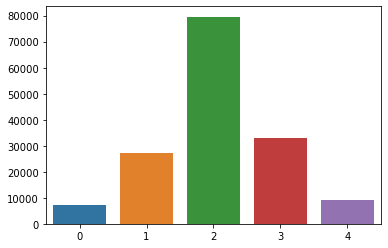

In [3]:
import seaborn as sbn

x = df['Sentiment'].value_counts()
sbn.barplot(x.index,x.values)

In [4]:
## Get the Independent Features
X=df['Phrase']
## Get the Dependent features
y=df['Sentiment']

print("Shape of a independent feature: ",X.shape)
print("Shape of a dependent feature: ",y.shape)

Shape of a independent feature:  (156060,)
Shape of a dependent feature:  (156060,)


---
## Data preprocessing


1. **Convert text to lowercase**
2. **Tokenization:** Tokenization is the process of splitting the given text into smaller pieces called tokens. Words, numbers, punctuation marks, and others can be considered as tokens.
3. **Stemming:** Stemming is a process of reducing words to their word stem, base or root form (for example, books — book, looked — look).

In [5]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer

ps = PorterStemmer()
tt = TweetTokenizer()
corpus = []

for i in range(0, len(X)):
    #review = re.sub('[^a-zA-Z]', ' ', X[i])
    review = X[i].lower()
    review = tt.tokenize(review)
    review = [ps.stem(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)

In [6]:
corpus[:8]

['a seri of escapad demonstr the adag that what is good for the goos is also good for the gander , some of which occasion amus but none of which amount to much of a stori .',
 'a seri of escapad demonstr the adag that what is good for the goos',
 'a seri',
 'a',
 'seri',
 'of escapad demonstr the adag that what is good for the goos',
 'of',
 'escapad demonstr the adag that what is good for the goos']

***
## One hot representation

A one hot encoding is a representation of categorical variables as binary vectors. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.
<br>

![alt text](./images/One-hot.png)

In [8]:
from tensorflow.keras.preprocessing.text import one_hot

### Vocabulary size
voc_size=15000

onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr[2:8]

[[12635, 13650],
 [12635],
 [13650],
 [4861, 11956, 5137, 13813, 7589, 529, 4105, 2252, 7297, 13733, 13813, 9049],
 [4861],
 [11956, 5137, 13813, 7589, 529, 4105, 2252, 7297, 13733, 13813, 9049]]

***
## Padding sequences

Deep learning libraries assume a vectorized representation of your data.
In the case of variable length sequence prediction problems, this requires that your data be transformed such that each sequence has the same length.
This vectorization allows code to efficiently perform the matrix operations in batch for your chosen deep learning algorithms.
[![alt text](./images/Padding.jpeg)](https://www.google.com/url?sa=i&url=https%3A%2F%2Ftowardsdatascience.com%2Fhow-to-use-lstm-network-to-build-a-story-generator-using-tensorflow-framework-b35964852d18&psig=AOvVaw2WrYFmuFOf2Mh0cmSr_CTN&ust=1593336944759000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCIj7nujYoeoCFQAAAAAdAAAAABAK)

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sent_length=40
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[    0     0     0 ...  4861 12635    74]
 [    0     0     0 ... 13733 13813  9049]
 [    0     0     0 ...     0 12635 13650]
 ...
 [    0     0     0 ...     0  3700  8323]
 [    0     0     0 ...     0     0  3700]
 [    0     0     0 ...     0     0  8323]]


***
## Creating Model

Here i am using Long short-term memory (LSTM), it is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video).

![](./images/lstm.png)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

tf.keras.backend.clear_session()

embedding_vector_features = 40

model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(5))
          
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 40)            600000    
_________________________________________________________________
dropout (Dropout)            (None, 40, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 656,905
Trainable params: 656,905
Non-trainable params: 0
_________________________________________________________________
None


***
## Training a model

In [11]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

### Spliting data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=8,batch_size=64)

Train on 104560 samples, validate on 51500 samples
Epoch 1/8
104560/104560 [==============================] - 41s 394us/sample - loss: 1.0617 - accuracy: 0.5742 - val_loss: 0.9159 - val_accuracy: 0.6231
Epoch 2/8
104560/104560 [==============================] - 32s 304us/sample - loss: 0.8856 - accuracy: 0.6382 - val_loss: 0.8723 - val_accuracy: 0.6419
Epoch 3/8
104560/104560 [==============================] - 33s 314us/sample - loss: 0.8347 - accuracy: 0.6550 - val_loss: 0.8692 - val_accuracy: 0.6454
Epoch 4/8
104560/104560 [==============================] - 31s 301us/sample - loss: 0.7998 - accuracy: 0.6703 - val_loss: 0.8544 - val_accuracy: 0.6506
Epoch 5/8
104560/104560 [==============================] - 32s 310us/sample - loss: 0.7757 - accuracy: 0.6781 - val_loss: 0.8537 - val_accuracy: 0.6521
Epoch 6/8
104560/104560 [==============================] - 32s 303us/sample - loss: 0.7555 - accuracy: 0.6861 - val_loss: 0.8480 - val_accuracy: 0.6574
Epoch 7/8
104560/104560 [============

In [12]:
y_pred=model.predict_classes(X_test)

***
## Evaluation

In [13]:
from sklearn.metrics import confusion_matrix

### Confusion Matrix
print("Confusion Matrix: ")
print()
print(confusion_matrix(y_test,y_pred))

Confusion Matrix: 

[[  765  1260   284    31     1]
 [  514  4634  3650   256     7]
 [   99  2152 21431  2249    67]
 [   11   238  4079  5974   688]
 [    2    16   260  1745  1087]]


In [14]:
from sklearn.metrics import accuracy_score

print("Accuracy score:",accuracy_score(y_test,y_pred))

Accuracy score: 0.6580776699029126


In [15]:
from sklearn.metrics import precision_score

print("Precision_score: ",precision_score(y_test,y_pred, average='weighted'))

Precision_score:  0.6472431731708634
